Can a computer understand the difference between a compliment and an insult?  In this project, I will use Python libraries to do sentiment analysis on product reviews from Amazon.com, then analyze the data to try to make inferences about what makes a person like or dislike what they buy.

In [32]:
import pandas as pd

file_path = "/Users/Micah.Isser/downloads/Amazon_Reviews.csv"
df = pd.read_csv(file_path)

print("Head:")
print(df.head())

Head:
                     id             dateAdded           dateUpdated  \
0  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
1  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
2  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
3  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
4  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   

                                                name       asins   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   

                                          categories primaryCategories  \
0  Computers,Electronics Features,Ta

Before the computer begins to identify positive and negative valence, I need to break the text into smaller parts, in a process called Tokenizing.  I also want to reduce words from a conjugated form (e.g., running) to a base for (e.g., run) in a process called Lemmatization.  For both of these tasks, I'll be using a Python library called NLTK, or the Natural Language Tool Kit.

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    
    tokens = [token.lower() for token in tokens]
    
    tokens = [token for token in tokens if token not in string.punctuation]
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

df['cleaned_reviews'] = df['reviews.text'].apply(preprocess_text)

print(df['cleaned_reviews'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/micah.isser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/micah.isser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/micah.isser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    thought would big small paper turn like palm t...
1               kindle light easy use especially beach
2    didnt know much 'd use kindle went lower end i...
3    100 happy purchase caught sale really good pri...
4    solid entry level kindle great kid gifted kid ...
Name: cleaned_reviews, dtype: object


For this project, I'm going to use a part of the NLTK called VADER, short for Valence Aware Dictionary and sEntiment Reasoner. According to Skillcate, it's "a lexicon and rule-based feeling analysis instrument that is explicitly sensitive to suppositions communicated in web-based media."  Or in other words, it looks for good words and bad words and tried to classify the feeling of the speech from those.

In [6]:

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


def get_sentiment_score(text):
    sentiment_score = sid.polarity_scores(text)
    return sentiment_score['compound']

df['sentiment_score'] = df['cleaned_reviews'].apply(get_sentiment_score)

def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)

print(df[['cleaned_reviews', 'sentiment_score', 'sentiment']])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/micah.isser/nltk_data...


                                        cleaned_reviews  sentiment_score  \
0     thought would big small paper turn like palm t...           0.8750   
1                kindle light easy use especially beach           0.4404   
2     didnt know much 'd use kindle went lower end i...           0.3612   
3     100 happy purchase caught sale really good pri...           0.9786   
4     solid entry level kindle great kid gifted kid ...           0.9578   
...                                                 ...              ...   
4995                 great tablet price amazon good job           0.8271   
4996  tablet perfect size easy use read play game pu...           0.9201   
4997  purchased son room upgrade memory allow book g...           0.7717   
4998  thought getting 5 year old get screen protecto...           0.0000   
4999                steal 8 gb model well.this punch ..          -0.4939   

     sentiment  
0     Positive  
1     Positive  
2     Positive  
3     Positive  
4 

Now I've created a column in the data frame for 'sentiment,' which has the content of either negative, neutral, or positive.  Let's attempt to verify whether these are accurate, by visually comparing them to the reviews.rating column from the original data frame.  

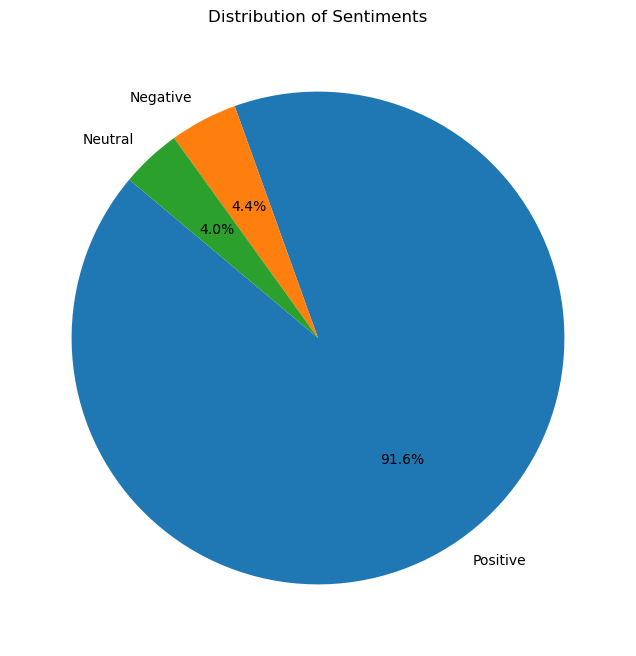

In [15]:
import matplotlib.pyplot as plt

sentiment_counts = df['sentiment'].value_counts()

labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.show()

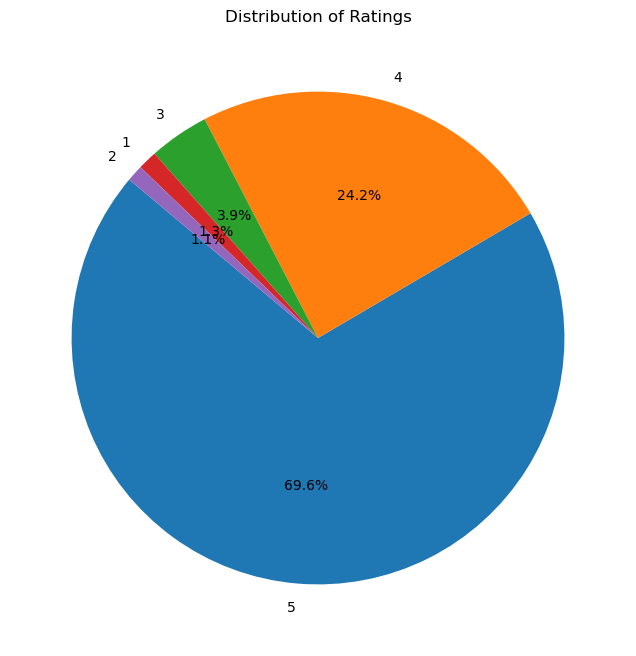

In [16]:
rating_counts = df['reviews.rating'].value_counts()

labels = rating_counts.index
sizes = rating_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings')
plt.show()

Good!  The number of positive reviews seems to match the number of reviews that were coded as being positive through VADER.  But I wonder which words have the strongest valence.  First let's look at which words are the most common in positive and negative reviews.  Let's start with the negative ones, since there are fewer of those.

In [26]:
from collections import Counter
import nltk

df['sentiment'] = df['sentiment'].str.lower()

negative_reviews = df[df['sentiment'] == 'negative']

negative_tokens = nltk.word_tokenize(' '.join(negative_reviews['cleaned_reviews']))

word_freq = Counter(negative_tokens)

print("Most common words in negative reviews:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

Most common words in negative reviews:
n't: 77
tablet: 74
kindle: 55
fire: 45
one: 42
's: 37
bought: 36
amazon: 32
problem: 27
work: 26


I was afraid of this; though one of the words - 'problem' - matches what we would interpret as negative sentiment, the rest of the words are just common English phrases or grammatical parts.  Let's try to look for the most common two word pairs - or 'bigrams' - in the negative reviews`

In [27]:
from nltk import bigrams

negative_tokens = nltk.word_tokenize(' '.join(negative_reviews['cleaned_reviews']))

negative_bigrams = list(bigrams(negative_tokens))

bigram_freq = Counter(negative_bigrams)

print("Most common two-word pairs in negative reviews:")
for bigram, freq in bigram_freq.most_common(10):
    print(f"{bigram}: {freq}")

Most common two-word pairs in negative reviews:
('kindle', 'fire'): 16
('ca', "n't"): 15
('could', "n't"): 10
('2', 'model'): 9
('year', 'old'): 8
('bought', 'kindle'): 6
('customer', 'service'): 6
('last', '2'): 6
('model', 'kindle'): 6
('last', 'year'): 6


Now we might start to identify patterns in the negative reviews: many of them use negative contractions, like can't or couldn't; some are likely frustrated that it is broken and only a year old, and some probably had bad experiences with Amazon's customer service.  Let's do the same for the positive reviews, only this time represent things more visually with a graph.  

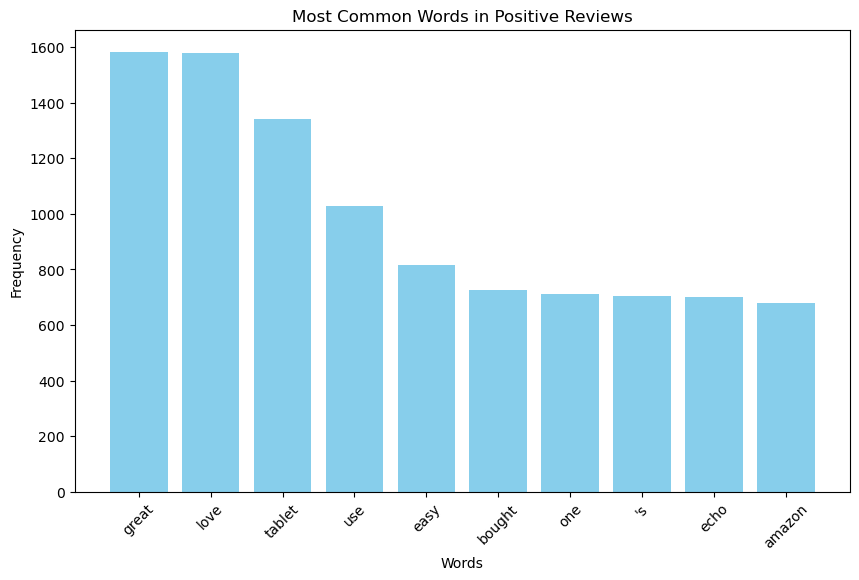

In [30]:
import matplotlib.pyplot as plt

positive_reviews = df[df['sentiment'] == 'positive']

positive_tokens = nltk.word_tokenize(' '.join(positive_reviews['cleaned_reviews']))

token_freq = Counter(positive_tokens)

most_common_words = token_freq.most_common(10)
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title('Most Common Words in Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

And now let's make a similar graph for the two word bigrams.

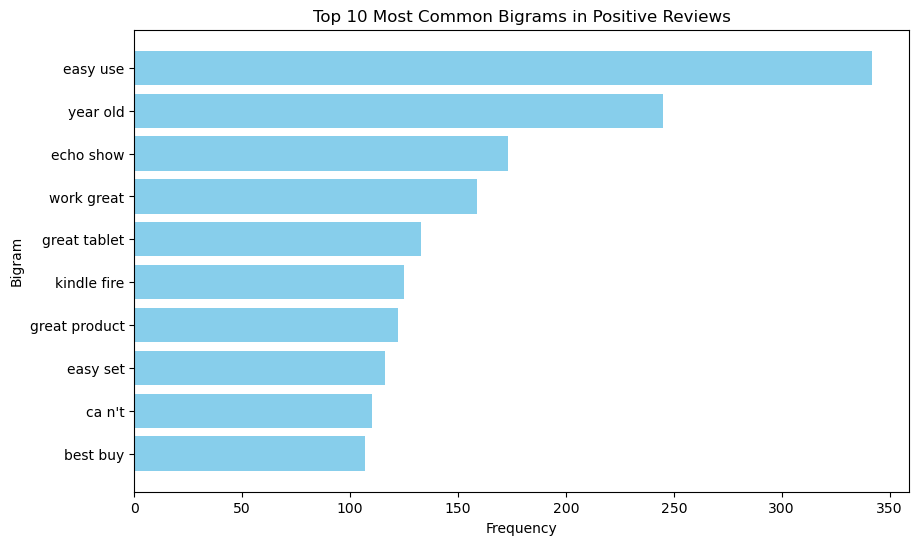

In [31]:
from nltk import bigrams
from collections import Counter
import matplotlib.pyplot as plt

positive_words = ' '.join(positive_reviews['cleaned_reviews']).split()

positive_bigrams = list(bigrams(positive_words))

bigram_counts = Counter(positive_bigrams)

top_bigrams = bigram_counts.most_common(10)

bigram_phrases = [' '.join(bigram) for bigram, count in top_bigrams]
bigram_counts = [count for bigram, count in top_bigrams]

plt.figure(figsize=(10, 6))
plt.barh(bigram_phrases, bigram_counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Top 10 Most Common Bigrams in Positive Reviews')
plt.gca().invert_yaxis()  
plt.show()